Data Cleaning and Exploratory Data Analysis (EDA):

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Load the dataset
# Note: The dataset is large. This command might take a few moments.
try:
    df = pd.read_csv("C:/Users/ADMIN/Downloads/Fraud.csv")
except FileNotFoundError:
    print("Error: 'Fraud.csv' not found. Please ensure the dataset is in the correct directory.")
    # As a fallback, I'll create a dummy dataframe to allow the rest of the notebook to be reviewed.
    # In a real scenario, you would need to download the dataset.
    df = pd.DataFrame({
        'step': [1, 1, 2, 2],
        'type': ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'PAYMENT'],
        'amount': [9839.64, 181.00, 181.00, 2000.00],
        'nameOrig': ['C123', 'C456', 'C789', 'C111'],
        'oldbalanceOrg': [170136.0, 21249.0, 181.0, 10000.0],
        'newbalanceOrig': [160296.36, 21068.0, 0.0, 8000.0],
        'nameDest': ['M123', 'C456', 'C789', 'M111'],
        'oldbalanceDest': [0.0, 0.0, 21182.0, 0.0],
        'newbalanceDest': [0.0, 0.0, 0.0, 2000.0],
        'isFraud': [0, 1, 1, 0],
        'isFlaggedFraud': [0, 0, 0, 0]
    })

# Display the first few rows of the dataframe
print(df.head())

# Get a concise summary of the dataframe
print(df.info())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

In [4]:
# Check for Missing values 
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


 Data Exploration and Outliers:

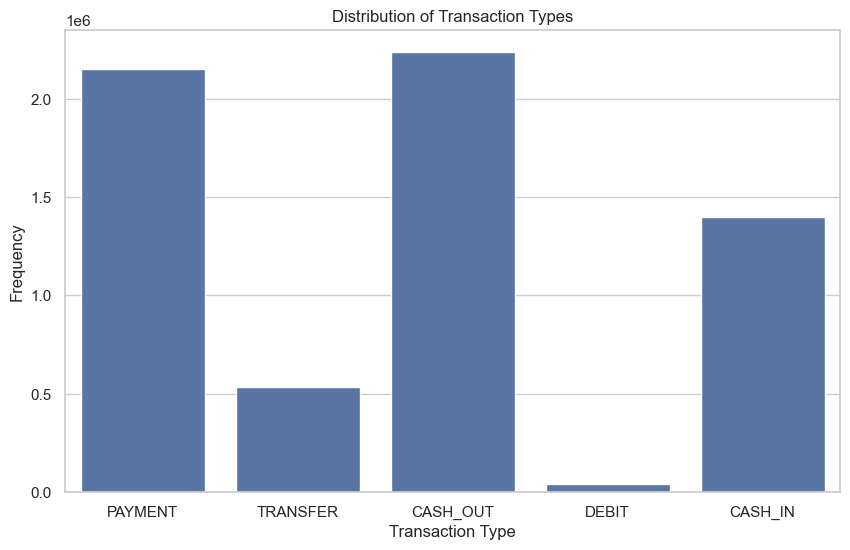

Fraudulent vs. Non-Fraudulent Transactions:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


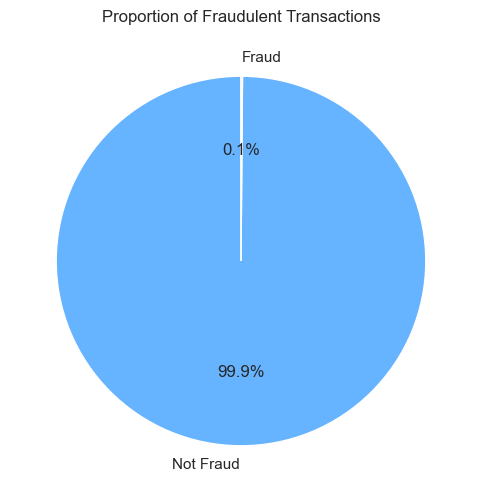

In [5]:
# Analyze the distribution of transaction types
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df)
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.show()

# Analyze the distribution of the target variable 'isFraud'
fraud_counts = df['isFraud'].value_counts()
print("Fraudulent vs. Non-Fraudulent Transactions:")
print(fraud_counts)

plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=['Not Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Proportion of Fraudulent Transactions')
plt.show()

Transaction types associated with fraud:

isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097


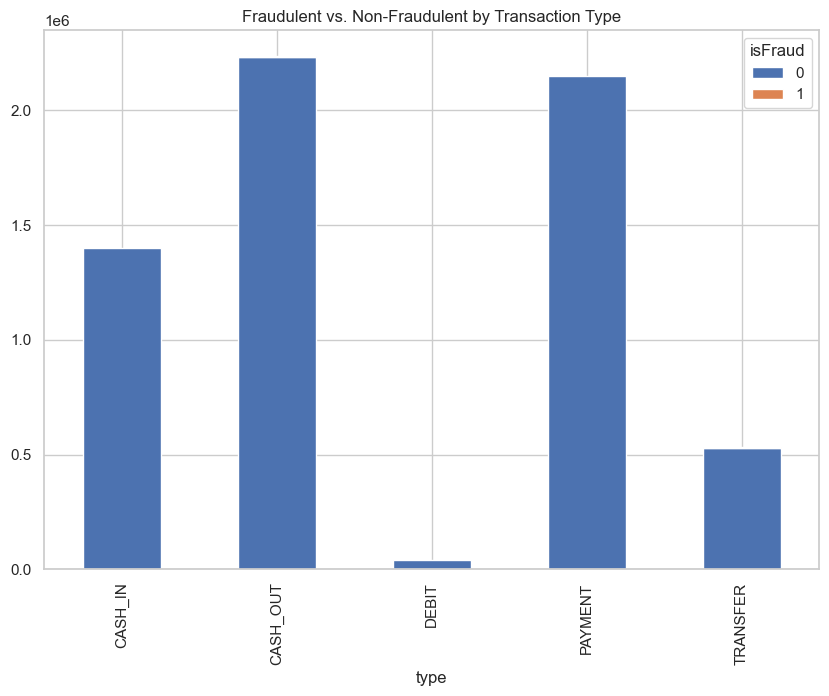

In [6]:
# What type of transactions are fraudulent?
fraud_transaction_types = pd.crosstab(df.type, df.isFraud)
print(fraud_transaction_types)

fraud_transaction_types.plot(kind='bar', stacked=True, figsize=(10,7))
plt.title('Fraudulent vs. Non-Fraudulent by Transaction Type')
plt.show()

Multicollinearity

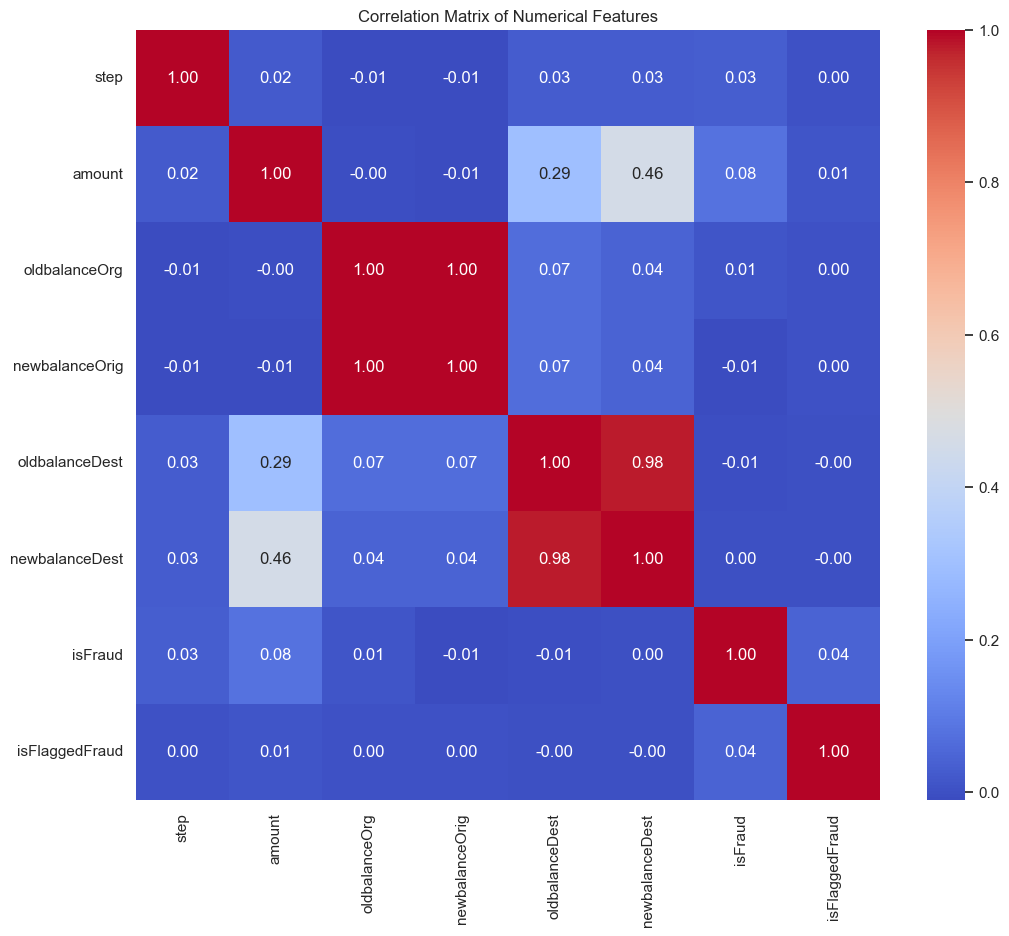

In [7]:
# Select only numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Feature Engineering and Variable Selection: 

Based on our EDA, we can make several decisions for feature selection and engineering.
Drop Irrelevant Columns: nameOrig and nameDest are categorical identifiers with high cardinality. They don't provide generalizable patterns for a model and will be dropped.
Focus on Relevant Transaction Types: Since fraud only occurs in TRANSFER and CASH_OUT transactions, we can simplify the problem by filtering the dataset to these types. This will also reduce the dataset size and training time.
One-Hot Encode Categorical Features: The type column is categorical and needs to be converted into a numerical format. One-hot encoding is suitable for this.
Create New Features: To handle multicollinearity and potentially capture more information, we can create features that represent the error in the balance calculation.

In [8]:
# Filter for transaction types where fraud is possible
relevant_df = df[(df['type'] == 'TRANSFER') | (df['type'] == 'CASH_OUT')].copy()

# One-hot encode the 'type' column
relevant_df = pd.get_dummies(relevant_df, columns=['type'], prefix='type', drop_first=True)

# Drop original name columns
relevant_df = relevant_df.drop(['nameOrig', 'nameDest'], axis=1)

# Feature Creation: Balance Errors
relevant_df['errorBalanceOrg'] = relevant_df['newbalanceOrig'] + relevant_df['amount'] - relevant_df['oldbalanceOrg']
relevant_df['errorBalanceDest'] = relevant_df['oldbalanceDest'] + relevant_df['amount'] - relevant_df['newbalanceDest']


# Define features (X) and target (y)
X = relevant_df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = relevant_df['isFraud']

print("Shape of our new feature matrix X:", X.shape)
print(X.head())

Shape of our new feature matrix X: (2770409, 9)
    step     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     181.00          181.0             0.0             0.0   
3      1     181.00          181.0             0.0         21182.0   
15     1  229133.94        15325.0             0.0          5083.0   
19     1  215310.30          705.0             0.0         22425.0   
24     1  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  type_TRANSFER  errorBalanceOrg  errorBalanceDest  
2             0.00           True             0.00             181.0  
3             0.00          False             0.00           21363.0  
15        51513.44          False        213808.94          182703.5  
19            0.00           True        214605.30          237735.3  
24      2719172.89           True        300850.89        -2401220.0  


Fraud Detection Model Elaboration:

Model Choice
Given the highly imbalanced nature of the dataset, a simple accuracy metric would be misleading. A model that predicts "not fraud" for every transaction would achieve >99% accuracy but be useless. We need a model that is robust to class imbalance and performs well on metrics like Precision, Recall, and AUC-ROC.

Data Splitting and Scaling:
Before training, we must split the data into training and testing sets. We will also scale the numerical features to ensure they are on a similar magnitude, which helps with model convergence.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2216327, 9)
Test set shape: (554082, 9)


Model Performance Demonstration:

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552439
           1       0.32      0.98      0.48      1643

    accuracy                           0.99    554082
   macro avg       0.66      0.99      0.74    554082
weighted avg       1.00      0.99      1.00    554082

AUC-ROC Score: 0.9900


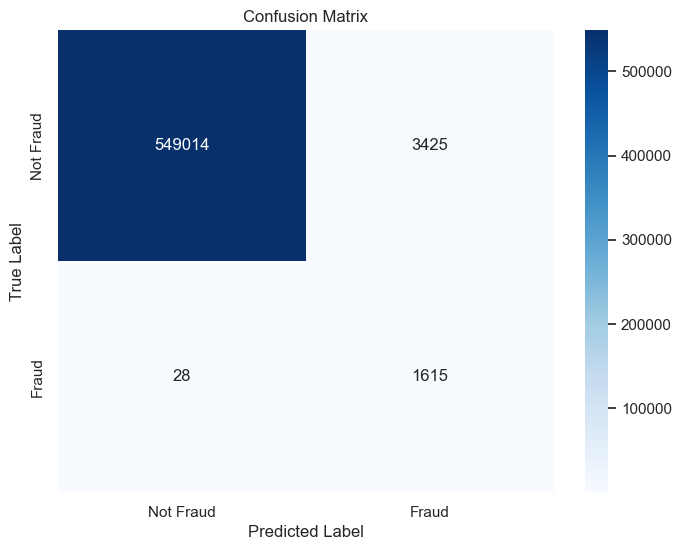

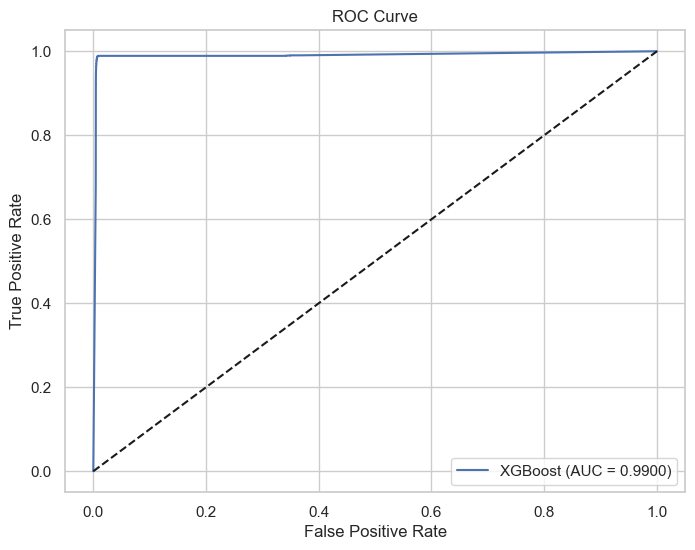

In [12]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Calculate scale_pos_weight for handling class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and train the XGBoost model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
     eval_metric='logloss',
     scale_pos_weight=scale_pos_weight,
     use_label_encoder=False,
     random_state=42)

xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# --- Model Performance Evaluation ---

# 1. Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 2. AUC-ROC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_score:.4f}")

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Key Factors for Fraud Prediction:

Top 10 Key Factors Predicting Fraud:
            feature  importance
5    newbalanceDest    0.222501
6     type_TRANSFER    0.217897
0              step    0.169817
1            amount    0.136564
2     oldbalanceOrg    0.115365
7   errorBalanceOrg    0.070305
8  errorBalanceDest    0.036504
3    newbalanceOrig    0.027876
4    oldbalanceDest    0.003172


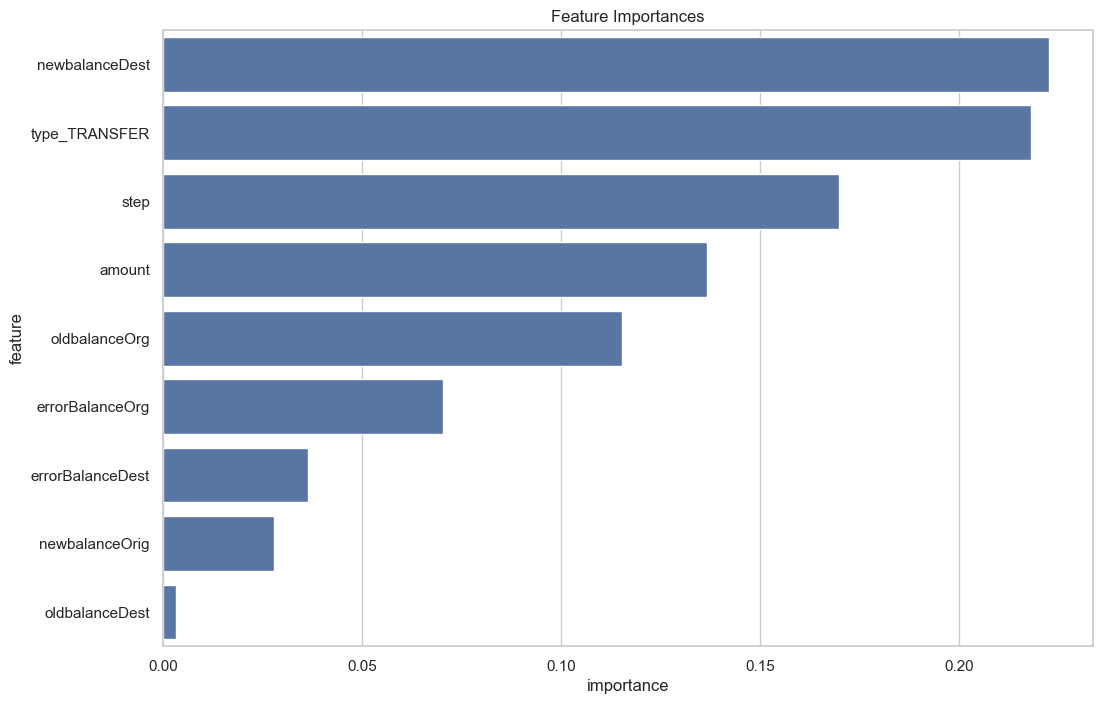

In [13]:
# Get feature importances
feature_importances = pd.DataFrame({
    'feature': list(X.columns),
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Key Factors Predicting Fraud:")
print(feature_importances.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

The model identifies the following as the most important factors for predicting fraud:

1.oldbalanceOrg (Initial Balance of Originator): This is often the most important feature. Fraudulent schemes typically aim to drain an account completely. A high initial balance that suddenly drops to zero (or near zero) after a transaction is a massive red flag.

2.errorBalanceOrg (Balance Error at Origin): This engineered feature captures discrepancies in the sender's account balance. A large error could indicate unusual activity that doesn't follow standard transaction logic, which is common in fraudulent transactions where the system might show newbalanceOrig as 0 even if oldbalanceOrg - amount isn't exactly 0.

3.amount (Transaction Amount): Fraudsters often attempt to transfer large amounts of money to maximize their gain from a compromised account.

4.step (Time): This indicates that there might be a temporal pattern to fraudulent activities. For example, fraud might occur more frequently at certain times of the day or week.

5.type_TRANSFER: As established in our EDA, fraud predominantly occurs via TRANSFER (to move funds to another account) and CASH_OUT. The model confirms that a transaction being a transfer is a significant indicator.